In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import folium
import time
from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [10]:
from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.
# Notice that this function returns only mini-batches of size `batchsize`.
# If the size of the data is not a multiple of `batchsize`, it will not
# return the last (remaining) mini-batch.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def train_mlp(model='mlp', num_epochs=50, learning_rate=0.001, train_shuffle=True, batchsize = 336):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor3('inputs')
    target_var = T.matrix('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    
    network = build_mlp(input_var)
    

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=learning_rate, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast = True)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], test_loss, allow_input_downcast = True)

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batchsize = batchsize, shuffle=train_shuffle):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, y_val.shape[0], shuffle=False):
            inputs, targets = batch
            #print (inputs.shape, targets.shape)
            err = val_fn(inputs, targets)
            val_err += err
            val_batches += 1
        
        # save the loss value
        train_loss[epoch] = train_err / train_batches
        val_loss[epoch] = val_err / val_batches
        
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_loss[epoch]))
        print("  validation loss:\t\t{:.6f}".format(val_loss[epoch]))    

    # After training, we compute and print the test error:
    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, y_test.shape[0], shuffle=False):
        inputs, targets = batch
        err = val_fn(inputs, targets)
        test_err += err
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    return network, train_loss, val_loss
# Optionally, you could now dump the network weights to a file like this:
# np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
#
# And load them again later on like this:
# with np.load('model.npz') as f:
#     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
# lasagne.layers.set_all_param_values(network, param_values)

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


### data preparation

In [7]:
olddata1 = np.load('data4/num_accident_2009-2015.npy')
olddata2 = np.load('data4/num_accident_tri_OHweekday_2009-2015.npy')
newdata = np.zeros(shape = (2352, 9))
newdata[:, 0:6] = olddata2[:,0:6]
newdata[:, 7] = (olddata1[:,1] - 0.5)/23.5
m = np.mean(olddata1[:,2])
st = np.std(olddata1[:,2])
print (m)
print (st)
newdata[:, 8] = (olddata1[:,2] - m)/st
np.save('data4/num_accident_OH_norm_2009-2015.npy', newdata)

17.4991496599
12.3690074871


### experiment on Monday

In [56]:
# Abstract Monday data
olddata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
newdata = np.zeros(shape = (336,2))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -2:]
    j+=1
    i+=336

In [19]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0].reshape(240,1,1), npdata[240:288, 0].reshape(48,1,1)
    y_train, y_val = npdata[0:240, -1].reshape(240,1), npdata[240:288, -1].reshape(48,1)
    x_test, y_test = npdata[288:336, 0].reshape(48,1,1), npdata[288:336, -1].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=1000, learning_rate=0.05, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.008s
  training loss:		2.191141
  validation loss:		0.877392
Epoch 2 of 1000 took 0.007s
  training loss:		1.028815
  validation loss:		0.900401
Epoch 3 of 1000 took 0.007s
  training loss:		1.057553
  validation loss:		0.882356
Epoch 4 of 1000 took 0.007s
  training loss:		1.040340
  validation loss:		0.885276
Epoch 5 of 1000 took 0.007s
  training loss:		1.044028
  validation loss:		0.882614
Epoch 6 of 1000 took 0.007s
  training loss:		1.041626
  validation loss:		0.882786
Epoch 7 of 1000 took 0.007s
  training loss:		1.041831
  validation loss:		0.882283
Epoch 8 of 1000 took 0.007s
  training loss:		1.041423
  validation loss:		0.882138
Epoch 9 of 1000 took 0.007s
  training loss:		1.041288
  validation loss:		0.881984
Epoch 10 of 1000 took 0.007s
  training loss:		1.041164
  validation loss:		0.881869
Epoch 11 of 1000 took 0.007s
  training loss:		1.041061
  validation loss:		0.88

In [21]:
np.savez('model/model_Monday1.npz', *lasagne.layers.get_all_param_values(network))
# Monday1: units = 15. number of hidden layer = 3. basis function = signmoid
# learning rate = 0.05
# first hidden layer: LSTM
# result: test loss = 0.23889 better than polynomial!!!

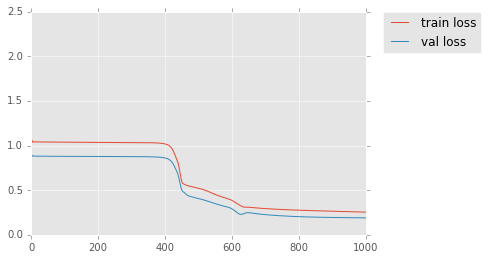

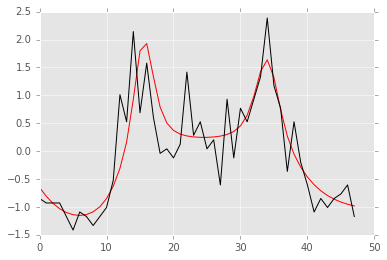

In [20]:
epoch = range(1000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0].reshape(48,1,1)).eval()
prediction = np.zeros(48)
prediction = output.reshape(48)

plt.figure()
plt.plot(prediction, color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')

/Users/XueqiWang/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


test loss:			0.243365379895


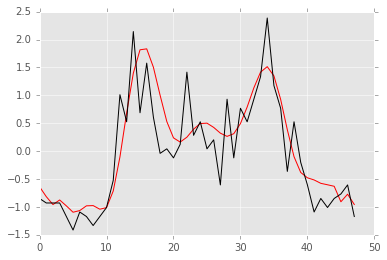

In [67]:
# Abstract Monday data
olddata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
newdata = np.zeros(shape = (336,2))
i = 48
j = 0
while j<7:
    newdata[j*48:j*48+48, :] = olddata[i:i+48, -2:]
    j+=1
    i+=336
npdata = newdata
x = npdata[0:288, 0]
y = npdata[0:288, 1]
z = np.polyfit(x, y, 25)
fitline = np.poly1d(z)

plt.figure()
plt.plot(fitline(npdata[288:336, 0]), color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')

# compute test loss
pre = fitline(npdata[288:336, 0])
ob = npdata[288:336, -1]
test_err = (pre - ob)**2
test_err = np.mean(test_err)
print ('test loss:\t\t\t{}'.format(test_err))

Try linear basis function

In [22]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0].reshape(240,1,1), npdata[240:288, 0].reshape(48,1,1)
    y_train, y_val = npdata[0:240, -1].reshape(240,1), npdata[240:288, -1].reshape(48,1)
    x_test, y_test = npdata[288:336, 0].reshape(48,1,1), npdata[288:336, -1].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.linear,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.linear,
            W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out


network, train_loss, val_loss = train_mlp(num_epochs=1000, learning_rate=0.05, train_shuffle = False, batchsize = 48)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.008s
  training loss:		1.037419
  validation loss:		0.916904
Epoch 2 of 1000 took 0.007s
  training loss:		1.057068
  validation loss:		0.900338
Epoch 3 of 1000 took 0.007s
  training loss:		1.048338
  validation loss:		0.895277
Epoch 4 of 1000 took 0.007s
  training loss:		1.045274
  validation loss:		0.889909
Epoch 5 of 1000 took 0.007s
  training loss:		1.041711
  validation loss:		0.885932
Epoch 6 of 1000 took 0.007s
  training loss:		1.038780
  validation loss:		0.882922
Epoch 7 of 1000 took 0.007s
  training loss:		1.036268
  validation loss:		0.880615
Epoch 8 of 1000 took 0.007s
  training loss:		1.034082
  validation loss:		0.878803
Epoch 9 of 1000 took 0.007s
  training loss:		1.032128
  validation loss:		0.877352
Epoch 10 of 1000 took 0.007s
  training loss:		1.030352
  validation loss:		0.876171
Epoch 11 of 1000 took 0.007s
  training loss:		1.028720
  validation loss:		0.87

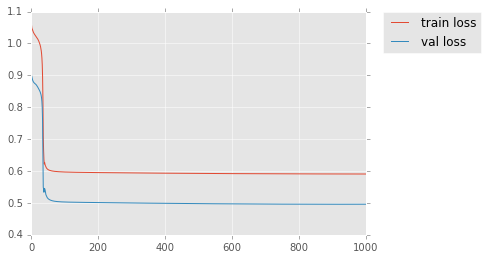

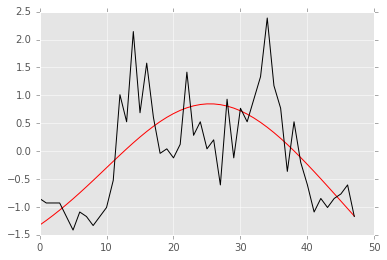

In [23]:
epoch = range(1000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0].reshape(48,1,1)).eval()
prediction = np.zeros(48)
prediction = output.reshape(48)

plt.figure()
plt.plot(prediction, color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 1000 took 0.008s
  training loss:		1.031870
  validation loss:		0.920557
Epoch 2 of 1000 took 0.007s
  training loss:		1.059025
  validation loss:		0.922385
Epoch 3 of 1000 took 0.008s
  training loss:		1.059588
  validation loss:		0.923372
Epoch 4 of 1000 took 0.007s
  training loss:		1.059820
  validation loss:		0.924632
Epoch 5 of 1000 took 0.007s
  training loss:		1.060142
  validation loss:		0.926054
Epoch 6 of 1000 took 0.007s
  training loss:		1.060523
  validation loss:		0.927532
Epoch 7 of 1000 took 0.007s
  training loss:		1.060932
  validation loss:		0.928975
Epoch 8 of 1000 took 0.007s
  training loss:		1.061339
  validation loss:		0.930292
Epoch 9 of 1000 took 0.007s
  training loss:		1.061719
  validation loss:		0.931403
Epoch 10 of 1000 took 0.007s
  training loss:		1.062045
  validation loss:		0.932234
Epoch 11 of 1000 took 0.007s
  training loss:		1.062296
  validation loss:		0.93

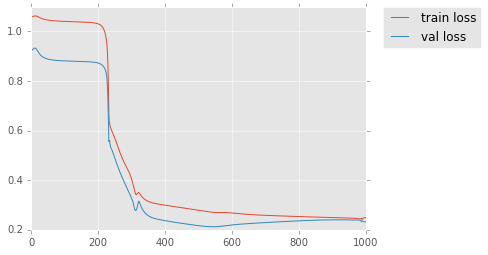

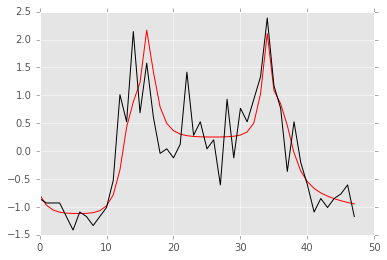

In [43]:
def load_dataset():
    npdata = newdata
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:240, 0].reshape(240,1,1), npdata[240:288, 0].reshape(48,1,1)
    y_train, y_val = npdata[0:240, -1].reshape(240,1), npdata[240:288, -1].reshape(48,1)
    x_test, y_test = npdata[288:336, 0].reshape(48,1,1), npdata[288:336, -1].reshape(48,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15, num_features = 1):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,num_features),
                                     input_var=input_var)

    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
      
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out

network, train_loss, val_loss = train_mlp(num_epochs=1000, learning_rate=0.08, train_shuffle = False, batchsize = 48)

epoch = range(1000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.ylim((0,1.1))
npdata = newdata
output = lasagne.layers.get_output(network, inputs= npdata[288:336, 0].reshape(48,1,1)).eval()
prediction = np.zeros(48)
prediction = output.reshape(48)

plt.figure()
plt.plot(prediction, color = 'r')
plt.plot(npdata[288:336, -1], color = 'k')

### Nueral network on all weekdays

In [73]:
def load_dataset():
    npdata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:1680, 0:-1].reshape(1680,1,8), npdata[1680:2016, 0:-1].reshape(336,1,8)
    y_train, y_val = npdata[0:1680, -1].reshape(1680,1), npdata[1680:2016, -1].reshape(336,1)
    x_test, y_test = npdata[2016:2352, 0:-1].reshape(336,1,8), npdata[2016:2352, -1].reshape(336,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,8),
                                     input_var=input_var)

    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
        
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out

network, train_loss, val_loss = train_mlp(num_epochs=2500, learning_rate=0.02)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 2500 took 0.024s
  training loss:		1.065274
  validation loss:		0.938805
Epoch 2 of 2500 took 0.022s
  training loss:		1.040132
  validation loss:		0.900589
Epoch 3 of 2500 took 0.024s
  training loss:		1.036936
  validation loss:		0.909051
Epoch 4 of 2500 took 0.023s
  training loss:		1.036141
  validation loss:		0.905310
Epoch 5 of 2500 took 0.024s
  training loss:		1.037053
  validation loss:		0.908110
Epoch 6 of 2500 took 0.024s
  training loss:		1.035165
  validation loss:		0.909633
Epoch 7 of 2500 took 0.023s
  training loss:		1.036290
  validation loss:		0.907225
Epoch 8 of 2500 took 0.023s
  training loss:		1.036284
  validation loss:		0.909807
Epoch 9 of 2500 took 0.022s
  training loss:		1.038144
  validation loss:		0.901337
Epoch 10 of 2500 took 0.024s
  training loss:		1.035856
  validation loss:		0.905940
Epoch 11 of 2500 took 0.026s
  training loss:		1.036094
  validation loss:		0.91

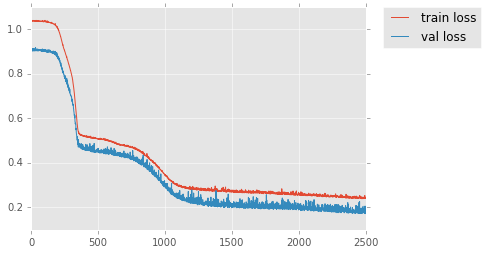

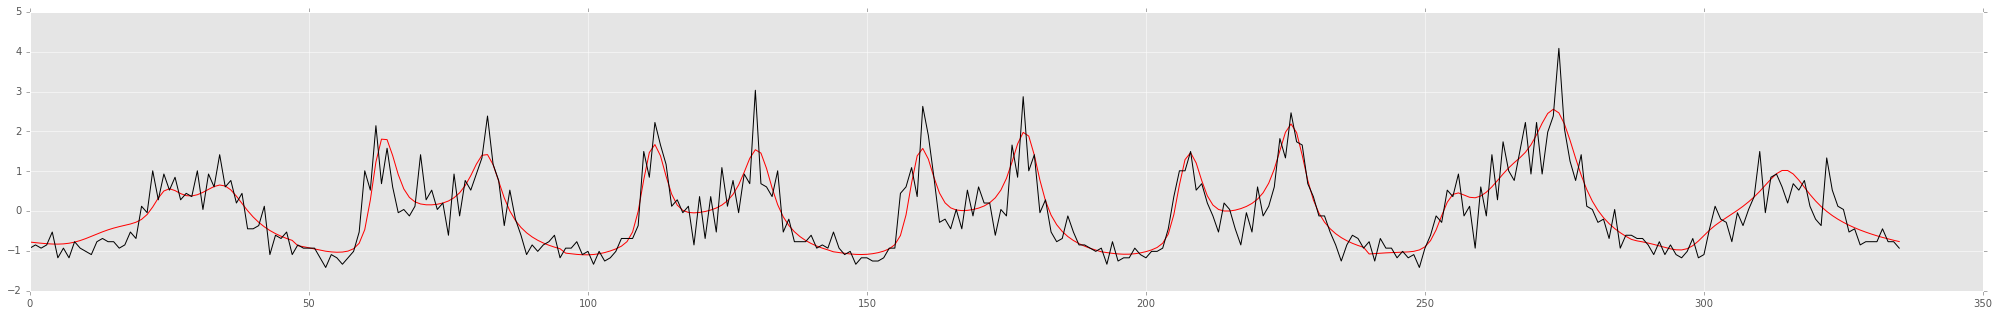

In [75]:
epoch = range(2500)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

npdata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
output = lasagne.layers.get_output(network, inputs= npdata[2016:2352, 0:-1].reshape(336,1,8)).eval()
prediction = np.zeros(336)
prediction = output.reshape(336)

plt.figure(figsize = (35,5))
plt.plot(prediction, color='r')
plt.plot(npdata[2016:2353, -1], color = 'k')

In [80]:
def load_dataset():
    npdata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
    npdata = npdata.astype(np.float32)
    X_train, X_val = npdata[0:1680, 0:-1].reshape(1680,1,8), npdata[1680:2016, 0:-1].reshape(336,1,8)
    y_train, y_val = npdata[0:1680, -1].reshape(1680,1), npdata[1680:2016, -1].reshape(336,1)
    x_test, y_test = npdata[2016:2352, 0:-1].reshape(336,1,8), npdata[2016:2352, -1].reshape(336,1)
    #print (X_train.shape, y_train.shape, X_val.shape, y_val.shape, npdata.shape)
    return X_train, y_train, X_val, y_val, x_test, y_test


def build_mlp(input_var=None, units = 15):
    
    # Input layer, specifying the expected input shape of the network
    l_in = lasagne.layers.InputLayer(shape=(None,1,8),
                                     input_var=input_var)

    l_hid1 = lasagne.layers.LSTMLayer(
            l_in, num_units = units)
    
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units = 20,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
    
    l_hid3 = lasagne.layers.DenseLayer(
            l_hid2, num_units = units*2,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform())
        
    l_out = lasagne.layers.DenseLayer(
            l_hid3, num_units=1,
            nonlinearity=lasagne.nonlinearities.linear)

    return l_out

network, train_loss, val_loss = train_mlp(num_epochs=2000, learning_rate=0.05)

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 2000 took 0.027s
  training loss:		1.215526
  validation loss:		0.897926
Epoch 2 of 2000 took 0.027s
  training loss:		1.041345
  validation loss:		0.973630
Epoch 3 of 2000 took 0.024s
  training loss:		1.047018
  validation loss:		0.897808
Epoch 4 of 2000 took 0.023s
  training loss:		1.040797
  validation loss:		0.900144
Epoch 5 of 2000 took 0.026s
  training loss:		1.040859
  validation loss:		0.897885
Epoch 6 of 2000 took 0.026s
  training loss:		1.061048
  validation loss:		0.932165
Epoch 7 of 2000 took 0.026s
  training loss:		1.038945
  validation loss:		0.913042
Epoch 8 of 2000 took 0.029s
  training loss:		1.040493
  validation loss:		0.952230
Epoch 9 of 2000 took 0.026s
  training loss:		1.042291
  validation loss:		0.898106
Epoch 10 of 2000 took 0.028s
  training loss:		1.041544
  validation loss:		0.936520
Epoch 11 of 2000 took 0.027s
  training loss:		1.048217
  validation loss:		0.90

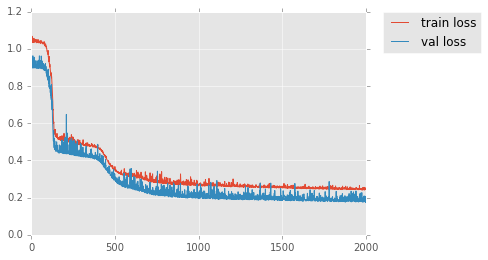

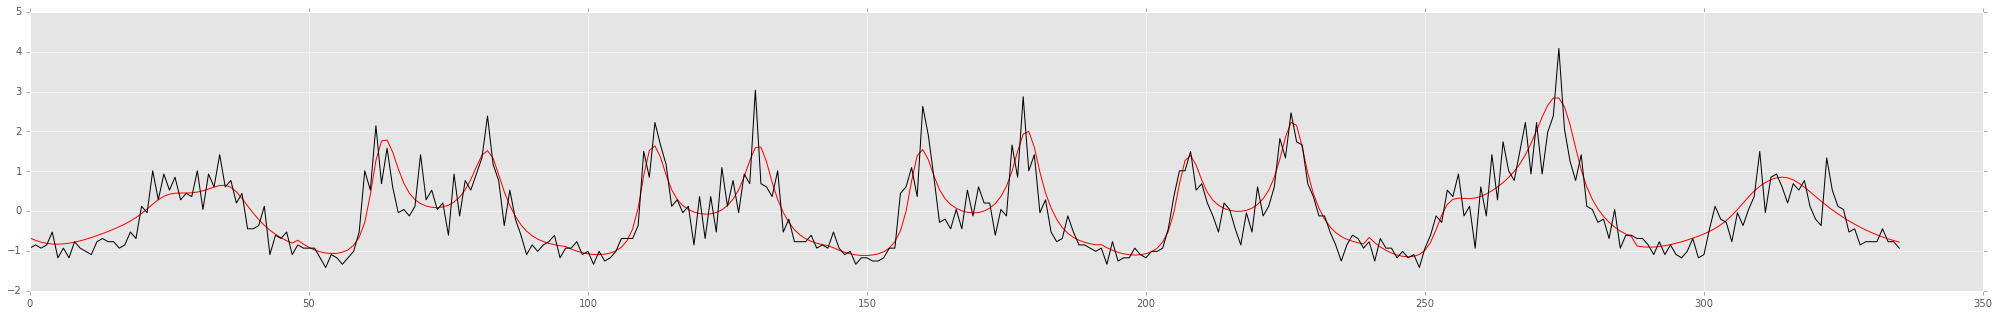

In [79]:
epoch = range(2000)
plt.figure()
plt.plot(epoch, train_loss, label = 'train loss')
plt.plot(epoch, val_loss, label = 'val loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

npdata = np.load('data4/num_accident_OH_norm_2009-2015.npy')
output = lasagne.layers.get_output(network, inputs= npdata[2016:2352, 0:-1].reshape(336,1,8)).eval()
prediction = np.zeros(336)
prediction = output.reshape(336)

plt.figure(figsize = (35,5))
plt.plot(prediction, color='r')
plt.plot(npdata[2016:2353, -1], color = 'k')